In [1]:
from typing import Tuple

#### Locating Assets

In [2]:
import cv2
from matplotlib import pyplot as plt


def locate_image_on_image(locate_image: str, on_image: str, prefix: str = '', visualize: bool = False, color: Tuple[int, int, int] = (0, 0, 255)):
    try:

        image = cv2.imread(on_image)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        template = cv2.imread(locate_image, 0)

        result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF)
        _, _, _, max_loc = cv2.minMaxLoc(result)

        height, width = template.shape[:2]

        top_left = max_loc
        bottom_right = (top_left[0] + width, top_left[1] + height)

        if visualize:
            cv2.rectangle(image, top_left, bottom_right, color, 1)
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)

        return {f'{prefix}top_left_pos': top_left, f'{prefix}bottom_right_pos': bottom_right}

    except cv2.error as err:
        print(err)

{'top_left_pos': (444, 57), 'bottom_right_pos': (534, 165)}

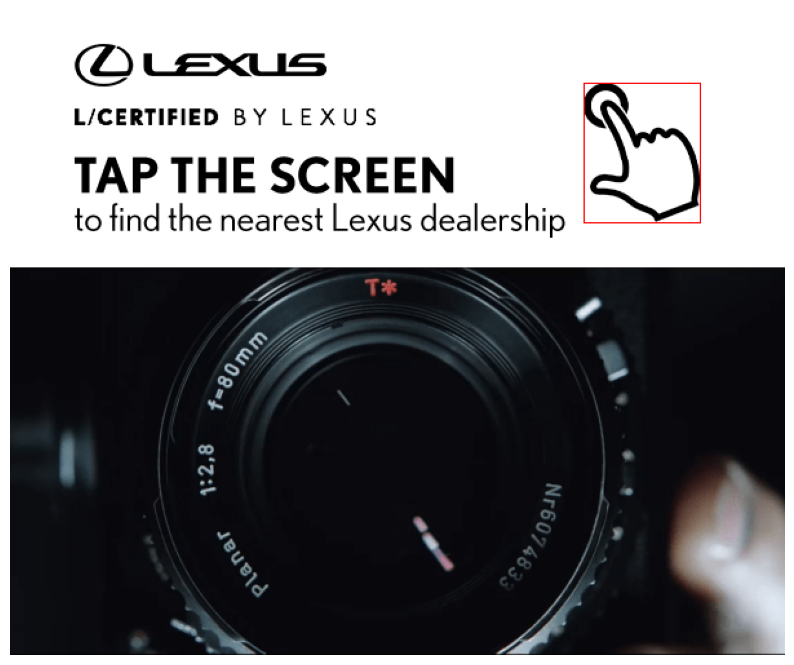

In [7]:
locate_image_on_image('../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_animation_1.png','../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png', visualize=True)

{'top_left_pos': (0, 0), 'bottom_right_pos': (600, 200)}

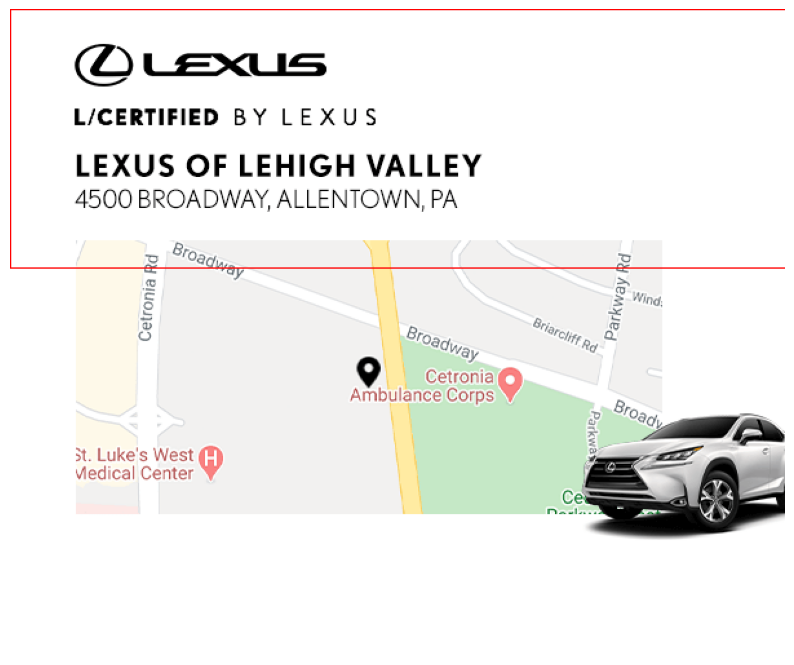

In [6]:
locate_image_on_image('../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg','../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/end-allentown.png', visualize=True)

#### Color extraction

Color extraction helps get;
- number of colors used
- background color
- text colors
- contrast etc.

In [8]:
import extcolors
import pandas as pd
from colormap import rgb2hex
from matplotlib import pyplot as plt
from PIL import Image

In [9]:
def identify_color_composition(image,
                               tolerance: int = 12,
                               limit: int = 2,
                               visualize: bool = False) -> None:
    """Function that identifies the color composition of a
    given image path."""

    extracted_colors = extcolors.extract_from_path(
        image, tolerance=tolerance, limit=limit)

    identified_colors = color_to_df(extracted_colors)

    if not visualize:
        return identified_colors

    list_color = list(identified_colors['c_code'])
    list_percent = [int(i) for i in list(identified_colors['occurrence'])]

    text_c = [c + ' ' + str(round(p*100/sum(list_percent), 1)) + '%' for c, p in zip(list_color,
                                                                                     list_percent)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100), dpi=10)
    wedges, _ = ax[0].pie(list_percent,
                          labels=text_c,
                          labeldistance=1.05,
                          colors=list_color,
                          textprops={'fontsize': 60, 'color': 'black'}
                          )

    plt.setp(wedges, width=0.3)

    # create space in the center
    plt.setp(wedges, width=0.36)

    ax[0].set_aspect("equal")
    fig.set_facecolor('grey')

    ax[1].imshow(Image.open(image))

    plt.show()

    return identified_colors


def color_to_df(extracted_colors: tuple):
    """Converts RGB Color values from extcolors output to HEX Values."""

    colors_pre_list = str(extracted_colors).replace(
        '([(', '').replace(')],', '), (').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')', '')
                  for i in colors_pre_list]

    # convert RGB to HEX code
    df_rgb_values = [(int(i.split(", ")[0].replace("(", "")),
                      int(i.split(", ")[1]),
                      int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(", "")),
                           int(i.split(", ")[1]),
                           int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    colors_df = pd.DataFrame(zip(df_color_up, df_rgb_values, df_percent),
                             columns=['c_code', 'rgb', 'occurrence'])

    return colors_df

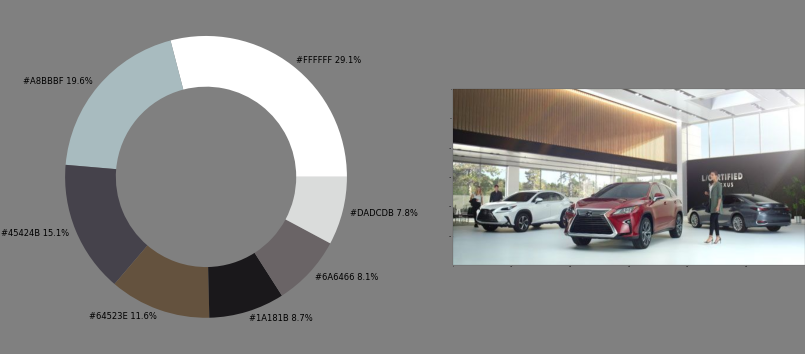

,c_code,rgb,occurrence
0,#FFFFFF,"(255, 255, 255)",40541
1,#A8BBBF,"(168, 187, 191)",27323
2,#45424B,"(69, 66, 75)",21087
3,#64523E,"(100, 82, 62)",16217
4,#1A181B,"(26, 24, 27)",12113
5,#6A6466,"(106, 100, 102)",11333
6,#DADCDB,"(218, 220, 219)",10916


In [13]:
identify_color_composition('../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/rev-thumbnail-mpu.jpg', limit=7,visualize=True)

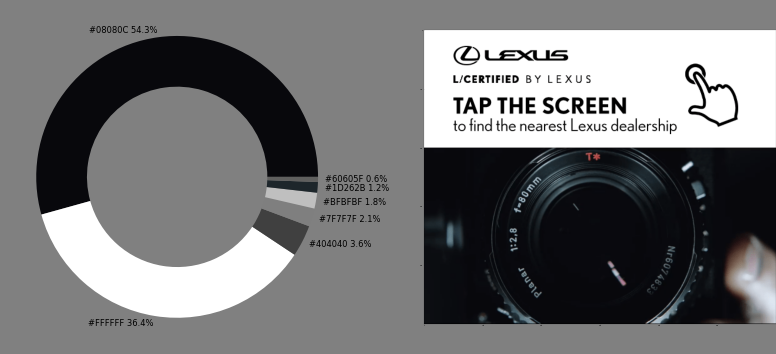

,c_code,rgb,occurrence
0,#08080C,"(8, 8, 12)",160951
1,#FFFFFF,"(255, 255, 255)",107778
2,#404040,"(64, 64, 64)",10730
3,#7F7F7F,"(127, 127, 127)",6176
4,#BFBFBF,"(191, 191, 191)",5379
5,#1D262B,"(29, 38, 43)",3606
6,#60605F,"(96, 96, 95)",1726


In [14]:
identify_color_composition('../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png', limit=7,visualize=True)

#### Text Extraction

In [16]:
import pytesseract
import cv2
import numpy as np
from typing import List, Tuple

In [17]:
def convert_hex_to_rgb(hex_color: str, normalize: bool = True) -> List[str]:
    """Converts a HEX color to a RGB color

    Args:
        hex_color (str): HEX color code to convert
        normalize (bool, optional): Choice to normalize calculated rgb values . Defaults to True.

    Returns:
        List[str]: List of RGB values in order, normalized or not.
    """
    colors = hex_color[1:]

    # Convert HEX color values to RGB Values
    colors = [int(colors[0:2], base=16),  # RED
              int(colors[2:4], base=16),  # GREEN
              int(colors[4:6], base=16)]  # BLUE

    # Normalize RGB values
    if normalize:
        colors = [color / 255 for color in colors]

    return colors

def get_luminance(hex_color: str) -> float:
    """Calculates the luminance of a given HEX color

    Args:
        hex_color (str): HEX color code to calculate luminance for

    Returns:
        float: luminance value of color
    """
    colors = convert_hex_to_rgb(hex_color)

    luminance = colors[0] * 0.2126 + colors[1] * 0.7152 + colors[2] * 0.0722

    return luminance

def fix_image_background(image_path: str):
    identified_colors = identify_color_composition(image_path)
    text_color = identified_colors['c_code'].to_list()[0]
    text_color_rgb = identified_colors['rgb'].to_list()[0]
    luminance = get_luminance(hex_color=text_color)

    if luminance < 140:
        background_color = (255, 255, 255)
    else:
        background_color = (0, 0, 0)

    # Load image
    image = cv2.imread(image_path)

    # Make all perfectly green pixels white
    image[np.all(image != text_color_rgb, axis=-1)] = background_color

    return image

def extract_text(image_path, tesseract_cmd: str = '', fix_background: bool = False):
    # pytesseract.pytesseract.tesseract_cmd = tesseract_cmd
    try:
        if fix_background:
            text = pytesseract.image_to_string(
                fix_image_background(image_path))
        else:
            text = pytesseract.image_to_string(image_path)

        return text

    except pytesseract.TesseractNotFoundError:
        raise Exception(
            f'Failure: Tesseract is not installed or not available in the defined path {tesseract_cmd}')

In [18]:
extract_text('../Challenge_Data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png')

'Ovexus\nL/CERTIFIED BY LEXUS\n\nTAP THE SCREEN\n\nto find the nearest Lexus dealership\n\n \n\x0c'

In [20]:
extract_text('../Challenge_Data/Assets/2a7069f1ccdc33dd1f7a200e3026b4ad/engagement_instruction.png')

'SWIPE Ul\n\nEQ A FIRST LOOR AT SEASON 6\n\x0c'